# Project - Fourth Requirement

### Include packages.

In [88]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy
from itertools import product

### Environment

Let's define some types of non-stationary environments...

In [89]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

With sinusoidally-varying "true value".

In [90]:
class PricingEnvironmentMultiProductSinusoidalMean:
    def __init__(self, costs, initial_mean_valuations, std_valuations, buyers_per_round, total_rounds, amplitudes, periods):
        # Initialize the environment
        self.costs = np.array(costs)  
        self.initial_mean_valuations = np.array(initial_mean_valuations)
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round  
        self.total_rounds = total_rounds
        self.current_round = 0

        # Each product has its own amplitude and period for the sinusoidal valuation
        self.amplitudes = np.array(amplitudes)
        self.periods = np.array(periods)

    def round(self, p_t_vector):
        # Define the valuations for each product at the current round
        mean_valuations = self.initial_mean_valuations + self.amplitudes * np.sin(2 * np.pi * self.current_round / self.periods)

        # Sample sales
        prob_buy = 1 - norm.cdf(np.array(p_t_vector), loc=mean_valuations, scale=self.std_valuations)
        num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy) 
        
        # Compute the reward and go on
        reward = ( p_t_vector - self.costs ) * num_sales
        self.current_round += 1
        return num_sales, reward

### Now define the setting...

In [91]:
# --- Global Settings ---

N = 3                       # Number of products
T = 20000                   # Time horizon
n_trials = 3                # Independent trials

# --- Pricing Grid and Product Info ---

K = 4

costs = np.array([2.0, 2.5, 3.0])             # Costs per product
initial_values = np.array([5.0, 6.0, 5.5])          # Initial mean valuations
std_valuations = np.array([1.0, 1.2, 0.8])          # Std for each product

assert len(costs) == len(initial_values) == len(std_valuations) == N, "costs, values, std_valuations must all be of length N"
assert np.all(costs < initial_values), "Each product's cost must be less than its corresponding value"

price_grids = []
for i in range(N):
    p_min = 0.5 * costs[i]
    p_max = initial_values[i] * 1.5
    price_grids.append(np.linspace(p_min, p_max, K))

# --- Market and Inventory Parameters ---

B = 120000 * N                                      # Total shared inventory

amplitudes = np.array([2.0, 1.5, 1.0])
periods = np.array([1000, 1500, 800])

buyers_per_round = 50                               # Number of buyers per round

# --- Other Parameters ---

s = 30                          # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

Let's visiualize it.

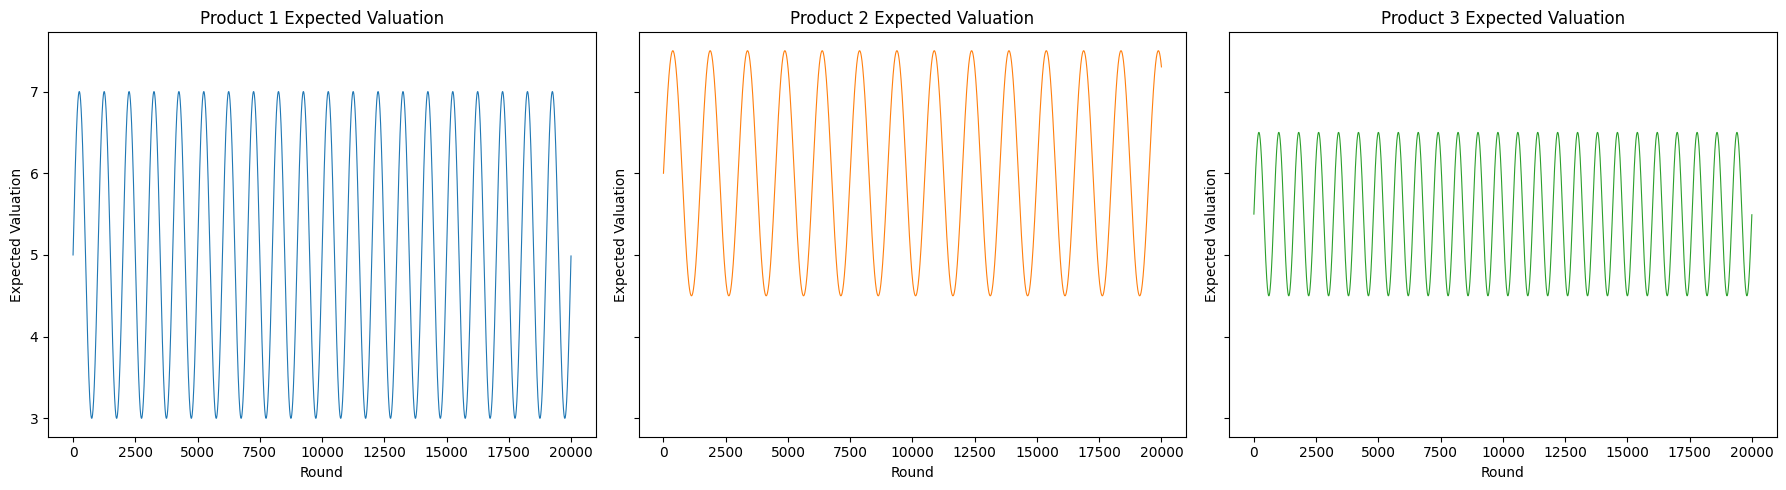

In [92]:
t_values = np.arange(T)

mean_valuations = np.zeros((N, T))
for i in range(N):
    mean_valuations[i] = initial_values[i] + amplitudes[i] * np.sin(2 * np.pi * t_values / periods[i])

# --- Plotting ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = [f'Product {i+1}' for i in range(N)]

for i in range(N):
    axs[i].plot(t_values, mean_valuations[i], color=colors[i], linewidth=0.8)
    axs[i].set_title(f'Product {i+1} Expected Valuation')
    axs[i].set_xlabel('Round')
    axs[i].set_ylabel('Expected Valuation')

plt.tight_layout()

### Design our agent

In [93]:
# ------------ Primal ------------- #

class EXP3P:
    def __init__(self, K, gamma, eta, max_reward_scale):
        self.K = K
        self.gamma = gamma                          # Exploration rate (how much we don't trust our weights)
        self.eta = eta                              # Learning rate
        self.weights = np.ones(K)
        self.probabilities = np.zeros(K)
        self.max_reward_scale = max_reward_scale    # Safe upper bound on absolute reward

    def choose_action(self):
        # Compute distribution out of weights and choose 
        self.probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + (self.gamma / self.K)
        self.probabilities /= np.sum(self.probabilities)  # Just in case
        return np.random.choice(self.K, p=self.probabilities)

    def update(self, chosen_action_idx, observed_reward):
        # Compute loss with normalized reward in [0,1]  
        loss_t = (1 - observed_reward / self.max_reward_scale) / 2
        if self.probabilities[chosen_action_idx] != 0:
            estimated_loss = loss_t / self.probabilities[chosen_action_idx]
        else:
            estimated_loss = loss_t
        # Update weights
        self.weights[chosen_action_idx] *= np.exp(-self.eta * estimated_loss)
        # In case weights are getting too large or too small, re-normalize
        if np.sum(self.weights) < 1e-100 or np.sum(self.weights) > 1e100:
            self.weights /= np.max(self.weights)

# ------------- Primal-Dual ------------ #

class PrimalDualCombinatorialPricingAgent:
    def __init__(self, prices, costs, initial_lambda, learning_rate_lambda=0.01, exp3p_gamma=0.001):
        self.prices = prices  # This is now a list of N arrays: prices[i][k]
        self.costs = costs
        self.N = len(prices)
        self.K = len(prices[0])
        self.rho = B / T if T > 0 else 1e-8
        self.lambda_t = initial_lambda
        self.eta_lambda = learning_rate_lambda
        self.superarms = list(product(range(self.K), repeat=self.N))
        self.remaining_budget = B
        self.current_round = 0
        self.max_reward_scale = np.sum([max(self.prices[i]) - self.costs[i] for i in range(self.N)]) * buyers_per_round
        self.history_lambda = [self.lambda_t]
        self.history_sales = []
        self.history_rho = [self.rho]

        # List of primal regret minimizers for each product
        self.primal_regret_minimizers = [ EXP3P(K=self.K, gamma=exp3p_gamma, eta=np.sqrt(np.log(self.K) / (self.K * T)), max_reward_scale=(max(self.prices[i]) - self.costs[i]) * buyers_per_round ) for i in range(self.N) ]

        # Exploration queue
        self.explored = np.zeros((self.N, self.K), dtype=bool)
        self.exploration_queue = []
        for i in range(self.N):
            for k in range(self.K):
                arm = [np.random.choice(range(self.K)) for _ in range(self.N)]
                arm[i] = k
                self.exploration_queue.append(tuple(arm))
        self.exploration_queue = list(dict.fromkeys(self.exploration_queue))

    def pull_arm(self):
        # Initial exploration (remember: explore all ARMS at least once)
        if not np.all(self.explored):
            superarm = self.exploration_queue.pop(0)
            prices = [self.prices[i][superarm[i]] for i in range(self.N)]
            for i in range(self.N):
                self.explored[i, superarm[i]] = True    
            return prices, superarm

        # Independent EXP3 sampling
        superarm = []
        for i in range(self.N):
            arm = self.primal_regret_minimizers[i].choose_action()
            superarm.append(arm)
        prices = [self.prices[i][superarm[i]] for i in range(self.N)]
        return prices, tuple(superarm)


    def update(self, chosen_arm_indices, sales_vector):
        prices = [self.prices[i][chosen_arm_indices[i]] for i in range(self.N)]
        rewards = [(prices[i] - self.costs[i]) * sales_vector[i] for i in range(self.N)]

        # Update all the regret minimizers
        for i in range(self.N):
            lagrangified_reward = rewards[i] - self.lambda_t * (sales_vector[i] - self.rho/N)
            self.primal_regret_minimizers[i].update(chosen_arm_indices[i], lagrangified_reward)

        # Dual update
        total_consumption = np.sum(sales_vector)
        self.remaining_budget -= total_consumption
        self.current_round += 1
        self.rho = self.remaining_budget / (T - self.current_round) if (T - self.current_round) > 0 else 1e-8
        self.history_rho.append(self.rho)

        self.lambda_t += self.eta_lambda * (total_consumption - self.rho)
        self.lambda_t = np.clip(self.lambda_t, 0, self.max_reward_scale)
        self.history_lambda.append(self.lambda_t)
        self.history_sales.append(total_consumption)

### Regret analysis

Run simulation

In [94]:
# --------- Simulation ---------

all_rewards = []
all_lambdas = []
all_probs = []
all_rho = []
all_sold_pieces = []

# For each trial, run the simulation
for seed in range(n_trials):
    np.random.seed(seed)

    # Initialize environment and agent
    env = PricingEnvironmentMultiProductSinusoidalMean(costs=costs, initial_mean_valuations=initial_values, std_valuations=std_valuations, buyers_per_round=buyers_per_round, total_rounds=T, amplitudes=amplitudes, periods=periods)
    agent = PrimalDualCombinatorialPricingAgent(prices=price_grids, costs=costs, initial_lambda=5*N)

    # For every round
    rewards_this_trial = []
    for t in range(T):

        # Terminate early: fill remaining rounds with 0
        if agent.remaining_budget < 1:
            rewards_this_trial.extend([0] * (T - t))
            break

        # Choose prices and get sales and reward
        price_vec, idx_vec = agent.pull_arm()
        sales_vec, reward_vec = env.round(price_vec)
        agent.update(idx_vec, sales_vec)

        # Store results for this trial
        rewards_this_trial.append(np.sum(reward_vec))
        # Store probs at last round
        if seed == n_trials - 1:
            if t == 0:
                all_probs = [[agent.primal_regret_minimizers[i].probabilities.copy() for i in range(agent.N)]]
            else:
                all_probs.append([agent.primal_regret_minimizers[i].probabilities.copy() for i in range(agent.N)])

    # Store results
    all_rewards.append(np.cumsum(rewards_this_trial))
    if seed == n_trials - 1:
        all_probs = np.array(all_probs)
    all_lambdas.append(agent.history_lambda)
    all_rho.append(agent.history_rho)
    all_sold_pieces.append(agent.history_sales)

if all_probs.shape[0] < T:
    pad_len = T - all_probs.shape[0]
    padding = np.zeros((pad_len, agent.N, agent.K))
    all_probs = np.concatenate((all_probs, padding), axis=0)

# --------- Analysis ---------

print(all_rho)

# Plotting cumulative utility
all_rewards = np.array(all_rewards)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)
print(f">>> Cumulative utility after {T} rounds: {mean_cum_util[-1]:.2f}")

[[18.0, np.float64(17.99599979999), np.float64(17.994549454945496), np.float64(17.992198829824474), np.float64(17.98999799959992), np.float64(17.98519629907477), np.float64(17.978593578073422), np.float64(17.97649177212024), np.float64(17.971338535414166), np.float64(17.96628482817268), np.float64(17.962181090545272), np.float64(17.955625594076743), np.float64(17.949069441665), np.float64(17.945014259268525), np.float64(17.938406884819372), np.float64(17.933550162621966), np.float64(17.930894715772617), np.float64(17.92563679127258), np.float64(17.920228205384845), np.float64(17.918022121014964), np.float64(17.915465465465466), np.float64(17.914009710195707), np.float64(17.91075182700971), np.float64(17.90569154527707), np.float64(17.903283940728876), np.float64(17.899374217772216), np.float64(17.899018724341644), np.float64(17.89600961297752), np.float64(17.89189865812137), np.float64(17.8877372189675), np.float64(17.881121682523787), np.float64(17.87841153788372), np.float64(17.87580

Compute clairvoyants

In [95]:
# ---------------------------------------
# Clairvoyant 1: Budget-Aware Fixed-Best 
# ---------------------------------------

mean_vals = np.array( [ initial_values[i] + amplitudes[i] * np.sin(2 * np.pi * np.arange(T) / periods[i]) for i in range(N) ] )

# For every superarm
best_superarm = None
best_reward = -np.inf
best_budget_spent = None
best_cum_rewards = None
all_superarms = list(product(*[ [p for p in price_grids[i] if p > costs[i]] for i in range(N)]))
for superarm in all_superarms:
    budget_spent = 0.0
    total_reward = 0.0
    cum_rewards = np.zeros(T)
    # For each round
    for t in range(T):
        expected_total_cost = 0.0
        expected_total_reward = 0.0
        # Compute expected cost and reward for this superarm
        for i in range(N):
            price = superarm[i]
            prob_buy = 1 - norm.cdf(price, loc=mean_vals[i, t], scale=std_valuations[i])
            expected_sales = prob_buy * buyers_per_round
            expected_total_cost += expected_sales * price
            expected_total_reward += expected_sales * (price - costs[i])
        if expected_total_cost <= (B - budget_spent):
            budget_spent += expected_total_cost
            total_reward += expected_total_reward
            cum_rewards[t] = cum_rewards[t - 1] + expected_total_reward if t > 0 else expected_total_reward
        else:
            scale = (B - budget_spent) / expected_total_cost if expected_total_cost > 0 else 0.0
            scaled_reward = expected_total_reward * scale
            budget_spent += (B - budget_spent)
            total_reward += scaled_reward
            cum_rewards[t] = cum_rewards[t - 1] + scaled_reward if t > 0 else scaled_reward
            cum_rewards[t + 1 :] = total_reward
            break
    # Check if this superarm is the best one found so far
    if total_reward > best_reward:
        best_reward = total_reward
        best_superarm = superarm
        best_budget_spent = budget_spent
        best_cum_rewards = cum_rewards

clairvoyant1_cum_rewards = best_cum_rewards
print(">>> Budget-Aware Fixed-Best Clairvoyant")
print(f"    Best static superarm: {', '.join(f'{p:.2f}' for p in best_superarm)}")
print(f"    Total expected reward: {clairvoyant1_cum_rewards[-1]:.2f}\n")

# -------------------------------------
# Clairvoyant 2: Overpower Clairvoyant
# -------------------------------------

# Take best price for each product at each round
clairvoyant2_cum_rewards = np.zeros(T)
for t in range(T):
    total_reward_t = 0.0
    for i in range(N):
        best_r = -np.inf
        for p in price_grids[i]:
            prob_buy = 1 - norm.cdf(p, loc=mean_vals[i, t], scale=std_valuations[i])
            exp_sales = prob_buy * buyers_per_round
            expected_reward = exp_sales * (p - costs[i])
            best_r = max(best_r, expected_reward)
        total_reward_t += best_r
    clairvoyant2_cum_rewards[t] = clairvoyant2_cum_rewards[t - 1] + total_reward_t if t > 0 else total_reward_t

print(">>> Overpower No-budget Clairvoyant")
print(f"    Total reward = {clairvoyant2_cum_rewards[-1]:.2f}\n")

# ---------------------------------------------------------------------------------------
# Clairvoyant 3: Budget-Aware Static-Mean Fixed-Price Clairvoyant
# ---------------------------------------------------------------------------------------

# Compute expected reward and budget per round for each superarm
superarms = list(product(*price_grids))
expected_rewards = {}
expected_costs = {}
for sa in superarms:
    total_r = 0
    total_c = 0
    for i, p in enumerate(sa):
        if p <= costs[i]:
            total_r = -np.inf  # invalid superarm
            break
        prob = 1 - norm.cdf(p, loc=initial_values[i], scale=std_valuations[i])
        sales = prob * buyers_per_round
        reward = sales * (p - costs[i])
        cost = sales * p
        total_r += reward
        total_c += cost
    expected_rewards[sa] = total_r
    expected_costs[sa] = total_c
# Pick best superarm that fits in the budget
valid_superarms = [sa for sa in superarms if expected_costs[sa] <= B]
best_sa = max(valid_superarms, key=lambda sa: expected_rewards[sa])
best_expected_profit = expected_rewards[best_sa]
budget_per_round = expected_costs[best_sa]
clairvoyant3_cum_rewards = np.zeros(T)
remaining_budget = B
for t in range(T):
    if remaining_budget >= budget_per_round:
        remaining_budget -= budget_per_round
        reward = expected_rewards[best_sa]
    else:
        reward = 0
    clairvoyant3_cum_rewards[t] = clairvoyant3_cum_rewards[t - 1] + reward if t > 0 else reward

# Summary print
print(f">>> Static Assumption Clairvoyant")
print(f"    Best static superarm: {', '.join(f'{float(p):.2f}' for p in best_sa)}")
print(f"    Total expected reward: {clairvoyant3_cum_rewards[-1]:.2f}\n")

>>> Budget-Aware Fixed-Best Clairvoyant
    Best static superarm: 7.50, 9.00, 8.25
    Total expected reward: 261650.53

>>> Overpower No-budget Clairvoyant
    Total reward = 4767625.85

>>> Static Assumption Clairvoyant
    Best static superarm: 5.33, 6.42, 6.00
    Total expected reward: 210638.66



Plot

Regret vs Budget-Aware Clairvoyant: -737390.4148433127
Regret vs No-Budget Clairvoyant: 3768584.9042128404
Regret vs Static Clairvoyant: -788402.2876633144


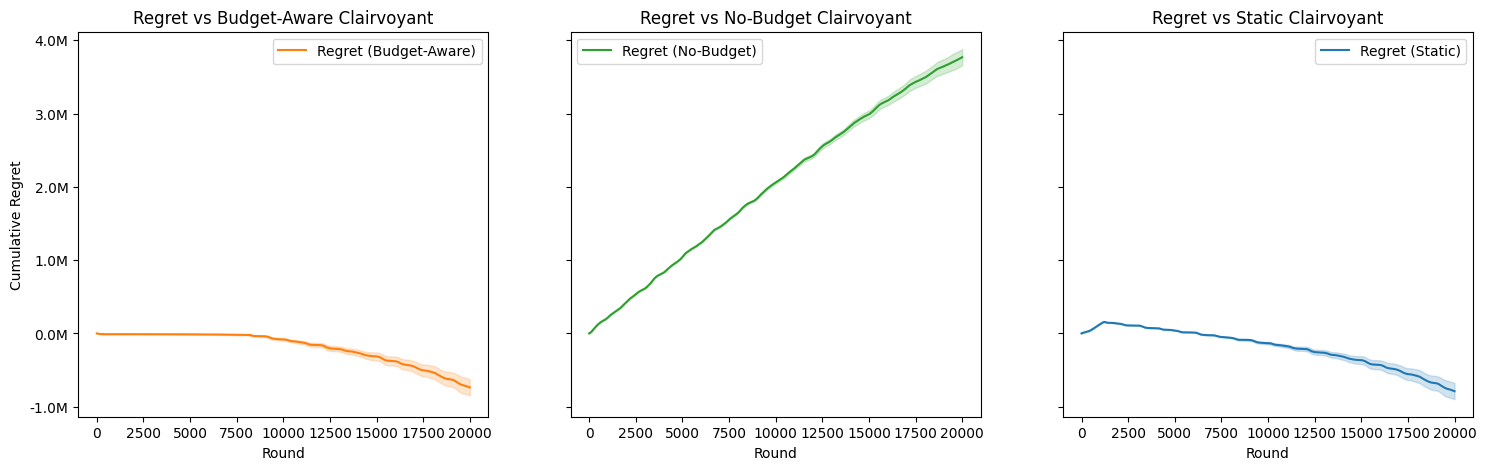

In [96]:
regret1 = clairvoyant1_cum_rewards - mean_cum_util
regret2 = clairvoyant2_cum_rewards - mean_cum_util
regret3 = clairvoyant3_cum_rewards - mean_cum_util

print("Regret vs Budget-Aware Clairvoyant:", regret1[-1])
print("Regret vs No-Budget Clairvoyant:", regret2[-1])
print("Regret vs Static Clairvoyant:", regret3[-1])

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Budget-Aware
axs[0].plot(regret1, color="tab:orange", label="Regret (Budget-Aware)")
axs[0].fill_between(np.arange(T), regret1 - std_cum_util, regret1 + std_cum_util, alpha=0.2, color="tab:orange")
axs[0].set_title("Regret vs Budget-Aware Clairvoyant")
axs[0].set_xlabel("Round")
axs[0].set_ylabel("Cumulative Regret")
axs[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
axs[0].legend()

# No-Budget
axs[1].plot(regret2, color="tab:green", label="Regret (No-Budget)")
axs[1].fill_between(np.arange(T), regret2 - std_cum_util, regret2 + std_cum_util, alpha=0.2, color="tab:green")
axs[1].set_title("Regret vs No-Budget Clairvoyant")
axs[1].set_xlabel("Round")
axs[1].legend()

# Static
axs[2].plot(regret3, color="tab:blue", label="Regret (Static)")
axs[2].fill_between(np.arange(T), regret3 - std_cum_util, regret3 + std_cum_util, alpha=0.2, color="tab:blue")
axs[2].set_title("Regret vs Static Clairvoyant")
axs[2].set_xlabel("Round")
_ = axs[2].legend()

### Further analysis

Lambda?

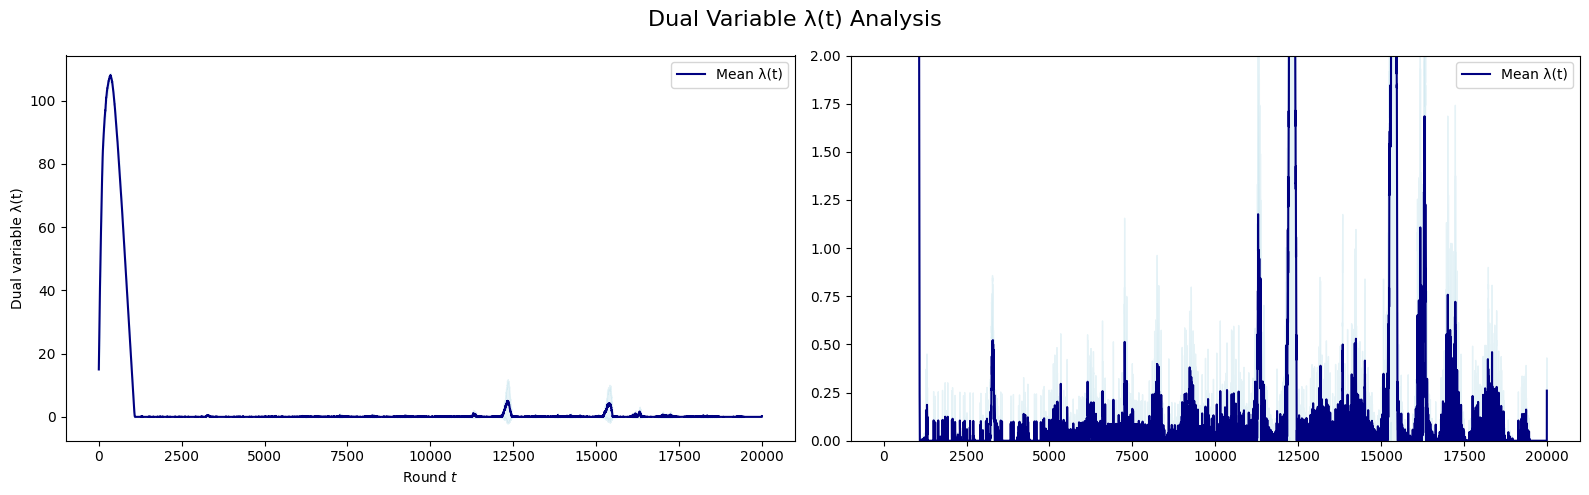

In [97]:
# --- Convert to arrays and compute statistics ---
min_len = min(len(l) for l in all_lambdas)
all_lambdas_trimmed = np.array([l[:min_len] for l in all_lambdas])
mean_lambda = np.mean(all_lambdas_trimmed, axis=0)
std_lambda = np.std(all_lambdas_trimmed, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=False)
fig.suptitle("Dual Variable λ(t) Analysis", fontsize=16)

# Plot mean lambda
axs[0].plot(mean_lambda, label='Mean λ(t)', color='navy')
axs[0].fill_between(np.arange(len(mean_lambda)), mean_lambda - std_lambda, mean_lambda + std_lambda, color='lightblue', alpha=0.3)
axs[0].set_xlabel('Round $t$')
axs[0].set_ylabel('Dual variable λ(t)')
axs[0].legend()

# Zoom in
axs[1].plot(mean_lambda, label='Mean λ(t)', color='navy')
axs[1].fill_between(np.arange(len(mean_lambda)), mean_lambda - std_lambda, mean_lambda + std_lambda, color='lightblue', alpha=0.3)
axs[1].set_ylim(0, 2)
axs[1].legend()

plt.tight_layout()

Consumption?

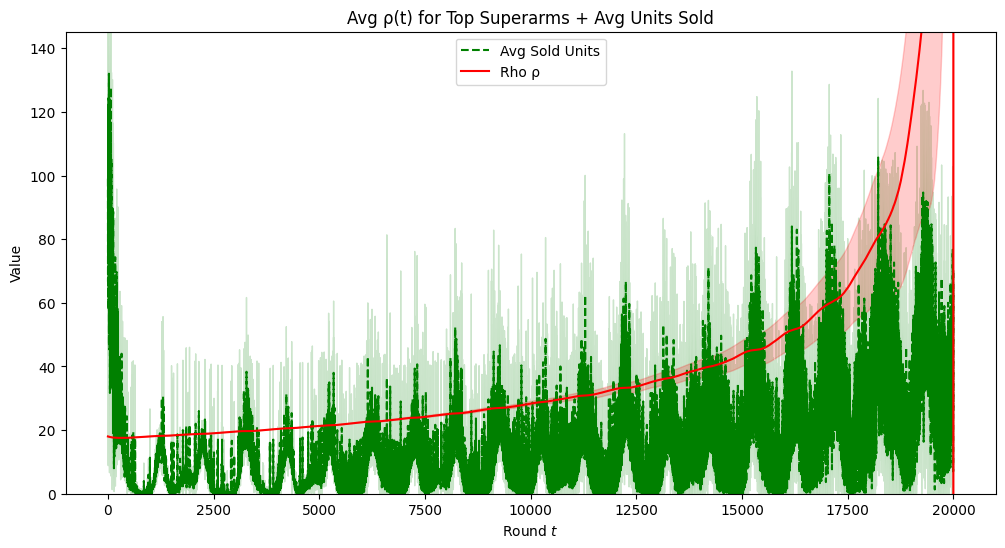

In [98]:
# --- Rho ---

# Determine if rho is scalar or vector
max_len = max(len(r) for r in all_rho)
all_rho_array = np.full((n_trials, max_len), np.nan)
for i, trial_rho in enumerate(all_rho):
    all_rho_array[i, :len(trial_rho)] = trial_rho

mean_rho = np.nanmean(all_rho_array, axis=0)
std_rho = np.nanstd(all_rho_array, axis=0)

# --- Sold pieces ---

max_len_sold = max(len(s) for s in all_sold_pieces)
all_sold_pieces_array = np.full((n_trials, max_len_sold), np.nan)
for i, s in enumerate([ [np.sum(s)] * len(s) if isinstance(s, np.ndarray) else s for s in all_sold_pieces ]):
    all_sold_pieces_array[i, :len(s)] = s
mean_sold_pieces = np.nanmean(all_sold_pieces_array, axis=0)
std_sold_pieces = np.nanstd(all_sold_pieces_array, axis=0)

# --- Plot ---

plt.figure(figsize=(12, 6))

plt.plot(mean_sold_pieces, label='Avg Sold Units', color='green', linestyle='--')
plt.fill_between(np.arange(len(mean_sold_pieces)), mean_sold_pieces - std_sold_pieces, mean_sold_pieces + std_sold_pieces, color='green', alpha=0.2)
plt.plot(mean_rho, label='Rho ρ', color='red', linestyle='-')
plt.fill_between(np.arange(len(mean_rho)), mean_rho - std_rho, mean_rho + std_rho, color='red', alpha=0.2)
plt.xlabel('Round $t$')
plt.ylabel('Value')
plt.title('Avg ρ(t) for Top Superarms + Avg Units Sold')
plt.ylim(0, max(mean_sold_pieces) * 1.1)
_ = plt.legend()